# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

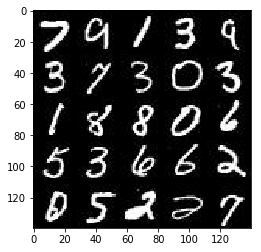

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

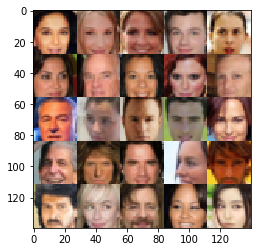

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.01
    with tf.variable_scope('discriminator', reuse=reuse) as discriminator:

        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 32, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*32))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    alpha = 0.01
    reuse = True if not is_train else False
    with tf.variable_scope('generator', reuse=reuse) as generator:
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
#         x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=1, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(alpha * x3, x3)

        x4 = tf.image.resize_nearest_neighbor(x2, (7,7))
        x4 = tf.layers.conv2d_transpose(x4, 128, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
#         x5 = tf.layers.conv2d_transpose(x4, 8, 5, strides=1, padding='same')
#         x5 = tf.layers.batch_normalization(x5, training=is_train)
#         x5 = tf.maximum(alpha * x5, x5)

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
#     smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_depth = 1 if data_image_mode == 'L' else 3
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    n_images = show_n_images
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_depth, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2400... Generator Loss: 0.1373
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 0.6474... Generator Loss: 1.0547
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 1.1181
Epoch 1/2... Discriminator Loss: 0.5786... Generator Loss: 1.4651
Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 1.3721
Epoch 1/2... Discriminator Loss: 0.5694... Generator Loss: 1.7085
Epoch 1/2... Discriminator Loss: 0.8882... Generator Loss: 0.8928


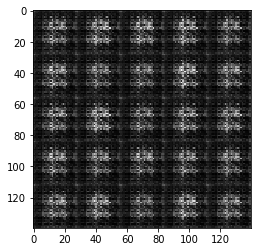

Epoch 1/2... Discriminator Loss: 0.2434... Generator Loss: 2.2019
Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 1.7141
Epoch 1/2... Discriminator Loss: 0.4127... Generator Loss: 1.6515
Epoch 1/2... Discriminator Loss: 0.3549... Generator Loss: 1.8372
Epoch 1/2... Discriminator Loss: 0.2677... Generator Loss: 1.9136
Epoch 1/2... Discriminator Loss: 0.2472... Generator Loss: 2.0704
Epoch 1/2... Discriminator Loss: 0.2715... Generator Loss: 1.8776
Epoch 1/2... Discriminator Loss: 0.3249... Generator Loss: 1.8885
Epoch 1/2... Discriminator Loss: 0.1899... Generator Loss: 2.3946
Epoch 1/2... Discriminator Loss: 0.2267... Generator Loss: 2.1785


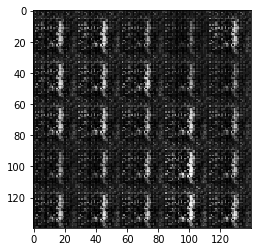

Epoch 1/2... Discriminator Loss: 0.1762... Generator Loss: 2.8988
Epoch 1/2... Discriminator Loss: 0.2274... Generator Loss: 1.9185
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 3.4000
Epoch 1/2... Discriminator Loss: 1.9657... Generator Loss: 0.1728
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 0.6208... Generator Loss: 1.3938
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.1586
Epoch 1/2... Discriminator Loss: 0.3019... Generator Loss: 3.1792
Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 1.2204


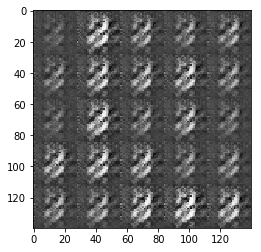

Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 1.8971
Epoch 1/2... Discriminator Loss: 0.4683... Generator Loss: 1.8344
Epoch 1/2... Discriminator Loss: 0.3648... Generator Loss: 1.6989
Epoch 1/2... Discriminator Loss: 0.2637... Generator Loss: 2.5603
Epoch 1/2... Discriminator Loss: 0.3871... Generator Loss: 2.6478
Epoch 1/2... Discriminator Loss: 0.4236... Generator Loss: 1.6933
Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 1.9489
Epoch 1/2... Discriminator Loss: 0.4252... Generator Loss: 2.2108
Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 1.4347
Epoch 1/2... Discriminator Loss: 0.4139... Generator Loss: 2.2873


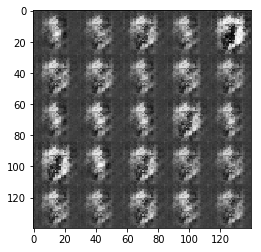

Epoch 1/2... Discriminator Loss: 0.2608... Generator Loss: 2.3357
Epoch 1/2... Discriminator Loss: 0.4406... Generator Loss: 1.6638
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 1.7912
Epoch 1/2... Discriminator Loss: 0.3156... Generator Loss: 1.8894
Epoch 1/2... Discriminator Loss: 0.5637... Generator Loss: 1.0925
Epoch 2/2... Discriminator Loss: 0.3563... Generator Loss: 2.2678
Epoch 2/2... Discriminator Loss: 0.4831... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 0.2865... Generator Loss: 1.9285
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 1.7537


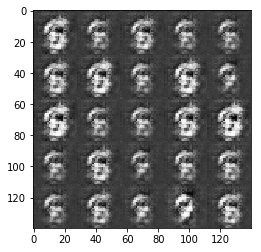

Epoch 2/2... Discriminator Loss: 0.2451... Generator Loss: 2.0177
Epoch 2/2... Discriminator Loss: 0.3330... Generator Loss: 4.1385
Epoch 2/2... Discriminator Loss: 0.3269... Generator Loss: 2.1907
Epoch 2/2... Discriminator Loss: 0.2528... Generator Loss: 2.4122
Epoch 2/2... Discriminator Loss: 0.2660... Generator Loss: 2.4944
Epoch 2/2... Discriminator Loss: 0.2220... Generator Loss: 2.6579
Epoch 2/2... Discriminator Loss: 0.2903... Generator Loss: 2.2848
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 4.3244
Epoch 2/2... Discriminator Loss: 0.2310... Generator Loss: 2.6824
Epoch 2/2... Discriminator Loss: 0.2773... Generator Loss: 2.3369


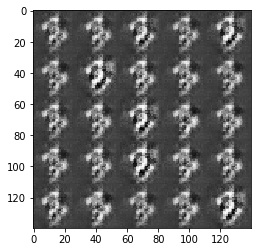

Epoch 2/2... Discriminator Loss: 0.2396... Generator Loss: 2.5943
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.5014
Epoch 2/2... Discriminator Loss: 0.2959... Generator Loss: 2.2534
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 0.7209
Epoch 2/2... Discriminator Loss: 0.2739... Generator Loss: 2.8355
Epoch 2/2... Discriminator Loss: 0.1747... Generator Loss: 2.8188
Epoch 2/2... Discriminator Loss: 0.2810... Generator Loss: 2.0099
Epoch 2/2... Discriminator Loss: 0.1800... Generator Loss: 2.7589
Epoch 2/2... Discriminator Loss: 0.1083... Generator Loss: 3.2331
Epoch 2/2... Discriminator Loss: 0.1411... Generator Loss: 2.5677


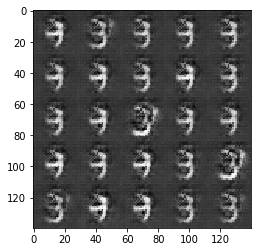

Epoch 2/2... Discriminator Loss: 0.1846... Generator Loss: 2.8664
Epoch 2/2... Discriminator Loss: 0.1722... Generator Loss: 3.4918
Epoch 2/2... Discriminator Loss: 0.2247... Generator Loss: 2.4844
Epoch 2/2... Discriminator Loss: 0.3039... Generator Loss: 2.0712
Epoch 2/2... Discriminator Loss: 0.2653... Generator Loss: 2.3977
Epoch 2/2... Discriminator Loss: 0.1842... Generator Loss: 2.8908
Epoch 2/2... Discriminator Loss: 0.2482... Generator Loss: 2.0269
Epoch 2/2... Discriminator Loss: 0.2933... Generator Loss: 2.2449
Epoch 2/2... Discriminator Loss: 0.2218... Generator Loss: 2.2919
Epoch 2/2... Discriminator Loss: 0.1968... Generator Loss: 2.2931


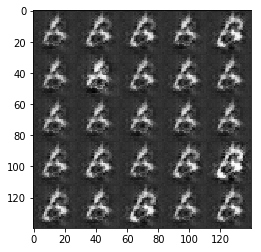

Epoch 2/2... Discriminator Loss: 0.1949... Generator Loss: 2.5290
Epoch 2/2... Discriminator Loss: 0.1602... Generator Loss: 2.8065
Epoch 2/2... Discriminator Loss: 0.1200... Generator Loss: 3.0885
Epoch 2/2... Discriminator Loss: 0.2761... Generator Loss: 5.0230
Epoch 2/2... Discriminator Loss: 0.2234... Generator Loss: 2.2480
Epoch 2/2... Discriminator Loss: 0.1214... Generator Loss: 2.9649
Epoch 2/2... Discriminator Loss: 0.0863... Generator Loss: 3.2715
Epoch 2/2... Discriminator Loss: 0.1359... Generator Loss: 2.6751
Epoch 2/2... Discriminator Loss: 0.2680... Generator Loss: 3.0891
Epoch 2/2... Discriminator Loss: 0.2132... Generator Loss: 2.7036


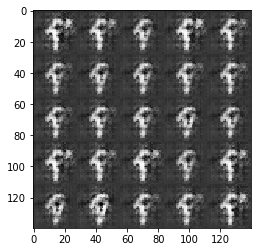

Epoch 2/2... Discriminator Loss: 0.2017... Generator Loss: 2.6531
Epoch 2/2... Discriminator Loss: 0.2981... Generator Loss: 1.8867
Epoch 2/2... Discriminator Loss: 0.1755... Generator Loss: 2.6335


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.3658... Generator Loss: 0.0176
Epoch 1/1... Discriminator Loss: 4.0734... Generator Loss: 0.0250
Epoch 1/1... Discriminator Loss: 3.6360... Generator Loss: 0.0409
Epoch 1/1... Discriminator Loss: 2.6423... Generator Loss: 0.1078
Epoch 1/1... Discriminator Loss: 2.7275... Generator Loss: 0.1213
Epoch 1/1... Discriminator Loss: 2.6304... Generator Loss: 0.1431
Epoch 1/1... Discriminator Loss: 2.5410... Generator Loss: 0.1905
Epoch 1/1... Discriminator Loss: 2.0709... Generator Loss: 0.2702
Epoch 1/1... Discriminator Loss: 2.8355... Generator Loss: 0.1953
Epoch 1/1... Discriminator Loss: 2.2041... Generator Loss: 0.3527


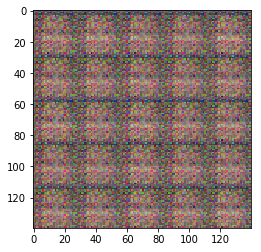

Epoch 1/1... Discriminator Loss: 2.4935... Generator Loss: 0.3331
Epoch 1/1... Discriminator Loss: 2.1441... Generator Loss: 0.3856
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 2.0850... Generator Loss: 0.4506
Epoch 1/1... Discriminator Loss: 1.9840... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.7814... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.5659


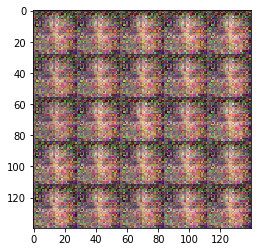

Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 0.1564... Generator Loss: 3.0626
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 2.6466
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 1.7807
Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 3.4829


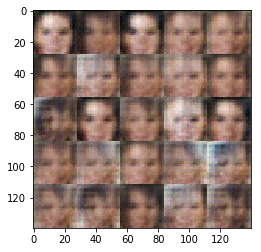

Epoch 1/1... Discriminator Loss: 0.1401... Generator Loss: 3.9323
Epoch 1/1... Discriminator Loss: 0.1032... Generator Loss: 3.5537
Epoch 1/1... Discriminator Loss: 0.2163... Generator Loss: 2.1714
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 3.5294
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 5.6868
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.2400... Generator Loss: 2.4707
Epoch 1/1... Discriminator Loss: 0.2746... Generator Loss: 1.8974
Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 1.3600


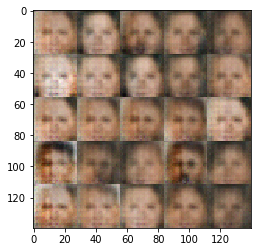

Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 4.6321
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 0.3024... Generator Loss: 1.9805
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 1.2278
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 2.2718
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 3.6388
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 2.3149
Epoch 1/1... Discriminator Loss: 0.1637... Generator Loss: 6.7284


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.